# Alexnet conv3 features with retinawarp
Here we're trying again to find a mapping from the alexnet conv3 feature space to the V4 voxel space.
This time we'll try preprocessing the images using "retinawarp" from the dicarlo lab (see Bashivan, P., Kar, K., & DiCarlo, J. J. (2019)). This notebook feeds those processed images to the Alexnet checkpoint and extracts the conv3 feature weights. 

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

import tensorflow as tf
from models import alexnet

from retina.retina_tf import warp_image

In [2]:
#Alexnet checkpoint
LOAD_PATH = "checkpoints/model.ckpt-115000"

In [3]:
STIM_PATH="/share/kalanit/biac2/kgs/projects/Dawn/CS431/data/full_res/"

In [4]:
#testing retinawarp with one training set (sets of 120 images)
with h5py.File(os.path.join(STIM_PATH,"Stimuli_Trn_FullRes_01.mat"),'r') as f:
    stim_set1 = f['stimTrn'][:]

/share/kalanit/biac2/kgs/projects/Dawn/CS431/v4_env/local/lib/python2.7/site-packages/retina/common.py:18: RuntimeWarning: overflow encountered in exp
  d.append(1. / np.sqrt(np.pi * rf) * np.exp(a * r[-1] / 2.))


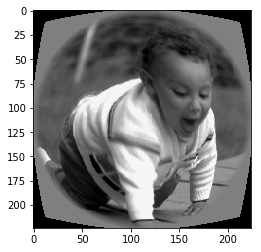

In [5]:
#make the actual pixel values match the alexnet training images
stim_set1 = stim_set1+.5

#transpose the images so that they make sense
stim_set1 = stim_set1.T

#add pretend color channels
N1 = stim_set1[:,:,:,np.newaxis]
stim_set1_rgb = np.tile(N1,(1,1,1,3))

# transform
with tf.Session() as sess:
    img = stim_set1_rgb[0,:,:,:]
    retina_img = warp_image(img, output_size=224)
    retina_img = retina_img.eval()

plt.imshow(retina_img) # woah cooool

In [6]:
stim_set1_rgb.shape[0]

120

In [11]:
#okay let's redo and pass these images through instead
num_train_batch = 15 
stim_set = []

for idx in range(0,num_train_batch):
    if idx < 9:
        base_str = ['Stimuli_Trn_FullRes_0','.mat']
    else:
        base_str = ['Stimuli_Trn_FullRes_','.mat']
            
    num = str(idx+1)
    
    fullfile = num.join(base_str)
    
    with h5py.File(os.path.join(STIM_PATH,fullfile),'r') as f:
        stim_set = f['stimTrn'][:]
        
    #make the actual pixel values match the alexnet training images
    stim_set = stim_set+.5

    #transpose the images so that they make sense
    stim_set = stim_set.T

    #add pretend color channels
    N = stim_set[:,:,:,np.newaxis]
    stim_set_rgb = np.tile(N,(1,1,1,3))
    
    # retina warp!
    stim_set_warped=np.zeros((stim_set_rgb.shape[0],224,224,3))
    with tf.Session() as sess:
        for im in range(stim_set_rgb.shape[0]):
            img = stim_set1_rgb[im,:,:,:]
            retina_img = warp_image(img, output_size=224)
            retina_img = retina_img.eval()
            stim_set_warped[im,:,:,:]= retina_img
    
    #create image tensor
    batch_images = stim_set_warped
    batch_image_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
       
    # initialize model
    batch_convnet = alexnet(batch_image_tensor)
    
    # initialize tf Session and restore weighs
    sess = tf.Session()
    tf_saver_restore = tf.train.Saver()
    tf_saver_restore.restore(sess, LOAD_PATH)
    # define output tensors of interest
    batch_conv3_outputs = batch_convnet.layers['conv3']

    # run whatever tensors we care about
    batch_conv3_outputs = sess.run(batch_conv3_outputs)
    
    if idx == 0:
        total_conv3_outputs = batch_conv3_outputs
    else:
        total_conv3_outputs = np.concatenate((total_conv3_outputs,batch_conv3_outputs),axis=0)
        
    print(total_conv3_outputs.shape)
    

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(120, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(240, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(360, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(480, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(600, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(720, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(840, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(960, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(1080, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(1200, 14, 14, 384)
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(1320, 14, 14, 3

In [14]:
# and now for the validation images

with h5py.File(os.path.join(STIM_PATH,"Stimuli_Val_FullRes.mat"),'r') as f:
        stim_set = f['stimVal'][:]
        
#make the actual pixel values match the alexnet training images
stim_set = stim_set+.5

#transpose the images so that they make sense
stim_set = stim_set.T

#add pretend color channels
N = stim_set[:,:,:,np.newaxis]
stim_set_rgb = np.tile(N,(1,1,1,3))

# retina warp!
stim_set_warped=np.zeros((stim_set_rgb.shape[0],224,224,3))
with tf.Session() as sess:
    for im in range(stim_set_rgb.shape[0]):
        img = stim_set1_rgb[im,:,:,:]
        retina_img = warp_image(img, output_size=224)
        retina_img = retina_img.eval()
        stim_set_warped[im,:,:,:]= retina_img
        
#create image tensor
val_images = stim_set_warped
val_image_tensor = tf.convert_to_tensor(val_images, dtype=tf.float32)

# initialize model
val_convnet = alexnet(val_image_tensor)

# initialize tf Session and restore weighs
sess = tf.Session()
tf_saver_restore = tf.train.Saver()
tf_saver_restore.restore(sess, LOAD_PATH)
# define output tensors of interest
val_conv3_outputs = val_convnet.layers['conv3']

# run whatever tensors we care about
val_conv3_outputs = sess.run(val_conv3_outputs)

print(val_conv3_outputs.shape)

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt-115000
(120, 14, 14, 384)


In [15]:
#let's save the features as h5py to use for fitting in another notebook
h5f = h5py.File('alexnet_conv3_features_retinawarp.h5', 'w')
h5f.create_dataset('train', data=total_conv3_outputs)
h5f.create_dataset('val', data=val_conv3_outputs)

<HDF5 dataset "val": shape (120, 14, 14, 384), type "<f4">

In [16]:
h5f.close()